In [1]:
!pip install torch
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install zarr
!pip install scikit-learn
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/easybuild_allnodes/software/Python/3.10.4-GCCcore-11.3.0/bin/python3.10 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/easybuild_allnodes/software/Python/3.10.4-GCCcore-11.3.0/bin/python3.10 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/easybuild_allnodes/software/Python/3.10.4-GCCcore-11.3.0/bin/python3.10 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/easybuild_allnodes/software/Python/3.10.4-GCCcore-11.3.0/bin/python3.10 -m pip install --upgrade pip' command.
Defaulting to user installation because norm

In [2]:
import cv2 as cv
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import zarr
import os
import tifffile as tiff
from sklearn.model_selection import KFold
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F

Preprocess the data, splitting to images and mask list

In [3]:
%matplotlib inline
# Paths to Zarr image dataset and TIFF mask
image_path = "REVA_Data/MethBlue-Eth-final_correct_filtered.zarr"
mask_path = "REVA_Data/methethblue_9_02_juri.tif"

# Reconstruct the annotated indices (every 10th slice, plus 61 and 78, excluding 120)
annotated_indices = list(range(0, 331, 10)) + [61, 78]  # Every 10 slices plus 61, 78
annotated_indices = np.array(annotated_indices)
annotated_indices = np.sort(annotated_indices)  # Sort to ensure the correct order

# Load the Zarr dataset, but retrieve only the slices corresponding to annotated_indices
dataset = zarr.open(image_path, mode='r')
selected_images = [dataset["images"][i] for i in annotated_indices]  # Load only the required slices

# Load the TIFF mask and retrieve only the slices corresponding to annotated_indices
selected_mask = tiff.imread(mask_path)
selected_mask = [selected_mask[i] for i in annotated_indices]


In [4]:
# Print the shapes to verify the loaded data
print(f"Selected images shape: {len(selected_images)}")
print(f"Selected mask shape: {len(selected_mask)}")

Selected images shape: 36
Selected mask shape: 36


Downsample the data

In [5]:
# Define crop dimensions (width x height)
crop_width = 5300
crop_height = 3000

# Get original dimensions from the first image in the dataset
original_height, original_width = selected_images[0].shape

# Calculate the starting points for center cropping
start_x = (original_width - crop_width) // 2
start_y = (original_height - crop_height) // 2

# Perform cropping on all images and masks
cropped_images = [img[start_y:start_y + crop_height, start_x:start_x + crop_width] for img in selected_images]
cropped_masks = [mask[start_y:start_y + crop_height, start_x:start_x + crop_width] for mask in selected_mask]

# Print shapes of cropped images and masks to verify the dimensions
print(f"Cropped images shape: {cropped_images[0].shape}")
print(f"Cropped masks shape: {cropped_masks[0].shape}")

Cropped images shape: (3000, 5300)
Cropped masks shape: (3000, 5300)


Split the dataset into train and test set. Each contains half the images and masks

In [6]:

# Assume cropped_images and cropped_masks are the lists of images and masks respectively
train_images, test_images, train_masks, test_masks = train_test_split(
    cropped_images, cropped_masks, test_size=0.5, random_state=42)
# Pair the training images and masks
train_data = [{"image": img, "mask": mask} for img, mask in zip(train_images, train_masks)]
# Pair the testing images and masks
test_data = [{"image": img, "mask": mask} for img, mask in zip(test_images, test_masks)]

Display masks and images

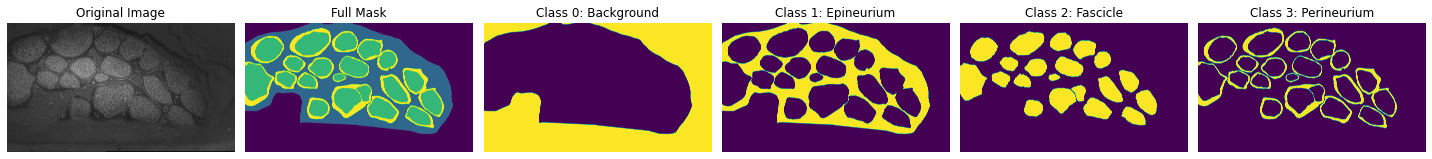

In [7]:

%matplotlib inline
slice = 1
train_image = train_data[slice]['image']  # Select the corresponding image (e.g., the first image)
train_mask = train_data[slice]['mask']  # Select the corresponding mask slice

# Get unique labels in the mask slice
unique_labels = np.unique(train_mask)
label_names = ['Background', "Epineurium", "Fascicle", "Perineurium"]

# Determine how many subplots are needed (1 for the image, 1 for the full mask, plus 1 for each unique label)
n_labels = len(unique_labels)
fig, axs = plt.subplots(1, 2 + n_labels, figsize=(20, 20))

# Plot the original image in the first subplot
axs[0].imshow(train_image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
plt.savefig('output_image.png', dpi=300)

# Plot the full mask in the second subplot
axs[1].imshow(train_mask, cmap='viridis')
axs[1].set_title('Full Mask')
axs[1].axis('off')

# Loop over each class (label) and display the corresponding binary mask
for i, label in enumerate(unique_labels):
    binary_mask = np.where(train_mask == label, 1, 0)  # Create a binary mask for the current label
    # Plot the binary mask for the current label in the corresponding subplot
    axs[2 + i].imshow(binary_mask, cmap='viridis')
    axs[2 + i].set_title(f'Class {label}: {label_names[int(label)]}')
    axs[2 + i].axis('off')
# Show the plot
plt.savefig("output.png")
plt.tight_layout()
plt.show()

In [8]:
print(np.unique(train_mask))

[0 1 2 3]


Attention Unet Implementation

In [9]:
class ConvBlock(nn.Module):
    """
    A convolutional block that consists of two convolutional layers,
    each followed by batch normalization and ReLU activation.
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    """
    An encoder block that applies a ConvBlock followed by MaxPooling.
    """
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        s = self.conv(x)
        p = self.maxpool(s)
        return s, p  # s: skip connection, p: pooled output

class AttentionGate(nn.Module):
    """
    An attention gate that refines skip connections by focusing on relevant features.
    """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g: gating signal from the decoder
        # x: skip connection from the encoder
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class DecoderBlock(nn.Module):
    """
    A decoder block that upsamples the input, applies an attention gate to the skip connection,
    concatenates the upsampled input with the refined skip connection, and applies a ConvBlock.
    """
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )
        self.attention = AttentionGate(
            F_g=out_channels, F_l=out_channels, F_int=out_channels // 2
        )
        self.conv = ConvBlock(in_channels=2 * out_channels, out_channels=out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)  # Upsample
        skip = self.attention(g=x, x=skip)  # Apply attention
        x = torch.cat([x, skip], dim=1)  # Concatenate along channel dimension
        x = self.conv(x)  # Apply ConvBlock
        return x

class AttentionUNet(nn.Module):
    """
    The Attention U-Net model that combines encoder blocks, decoder blocks with attention gates,
    and produces segmentation output.
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionUNet, self).__init__()
        # Encoder path
        self.e1 = EncoderBlock(in_channels, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Decoder path
        self.d1 = DecoderBlock(1024, 512)
        self.d2 = DecoderBlock(512, 256)
        self.d3 = DecoderBlock(256, 128)
        self.d4 = DecoderBlock(128, 64)

        # Final output layer
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        s1, p1 = self.e1(x)  # s1: skip connection
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        # Output
        output = self.output_conv(d4)
        return output  # Return raw logits; apply activation outside if needed

In [10]:
from torch.utils.data import Dataset, DataLoader
# 1. Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample['image']
        mask = sample['mask']
        
        # Convert mask to np.uint8
        mask = mask.astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        mask = mask.long()

        return image, mask

In [11]:
import albumentations as A
# 2. Data Augmentation
def get_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Resize(height = 512, width = 512),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

In [12]:
# 3. Data Loaders
def get_data_loaders(train_data, val_data, batch_size, transform):
    train_dataset = SegmentationDataset(train_data, transform=transform)
    val_dataset = SegmentationDataset(val_data, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

# 4. Cross-Validation Splits
def get_kfold_splits(data, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    splits = []
    data_indices = np.arange(len(data))
    for train_idx, val_idx in kf.split(data_indices):
        train_data = [data[i] for i in train_idx]
        val_data = [data[i] for i in val_idx]
        splits.append((train_data, val_data))
    return splits

def compute_dice_loss_per_class(inputs, targets, num_classes, smooth=1e-6):
    inputs = F.softmax(inputs, dim=1)
    targets_one_hot = F.one_hot(targets, num_classes=num_classes)  # (N, H, W, C)
    targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # (N, C, H, W)

    dims = (0, 2, 3)
    intersection = torch.sum(inputs * targets_one_hot, dims)
    cardinality = torch.sum(inputs + targets_one_hot, dims)

    dice_loss_per_class = 1 - (2. * intersection + smooth) / (cardinality + smooth)

    return dice_loss_per_class  # Returns a tensor of shape (num_classes,)

# Plotting Function
def plot_losses(history):
    # Convert history to a pandas DataFrame for easier plotting
    history_df = pd.DataFrame(history)

    num_folds = history_df['fold'].nunique()
    plt.figure(figsize=(12, 6))

    for fold in range(1, num_folds + 1):
        fold_history = history_df[history_df['fold'] == fold]
        plt.plot(fold_history['epoch'], fold_history['train_loss'], label=f'Fold {fold} Train Loss')
        plt.plot(fold_history['epoch'], fold_history['val_loss'], label=f'Fold {fold} Val Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Fold')
    plt.legend()
    plt.grid(True)
    plt.show()

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


In [13]:
# 5. Dice Loss Function
class MultiClassDiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(MultiClassDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        num_classes = inputs.shape[1]
        inputs = F.softmax(inputs, dim=1)

        targets_one_hot = F.one_hot(targets, num_classes=num_classes)  # (N, H, W, C)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # (N, C, H, W)

        dims = (0, 2, 3)
        intersection = torch.sum(inputs * targets_one_hot, dims)
        cardinality = torch.sum(inputs + targets_one_hot, dims)

        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1 - dice_score.mean()

        return dice_loss

In [23]:
def train_model(data_splits, num_epochs=50, batch_size=4, num_classes=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Initialize a dictionary to store losses and metrics
    history = {
        'fold': [],
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'train_dice_loss': [],
        'val_dice_loss': []
    }
    
    for fold, (train_data, val_data) in enumerate(data_splits):
        print(f'\nStarting Fold {fold + 1}/{len(data_splits)}')
        train_loader, val_loader = get_data_loaders(train_data, val_data, batch_size, transform=get_transforms())
        # Initialize the model for each fold
        model = AttentionUNet(in_channels=1, out_channels=num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        criterion = MultiClassDiceLoss()

        for epoch in range(num_epochs):
            model.train()
            # Reset model weights at the start of each fold
            train_loss = 0.0
            train_dice_loss_per_class = torch.zeros(num_classes).to(device)
            train_batches = 0

            for images, masks in train_loader:
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * images.size(0)
                train_batches += images.size(0)

                # Compute per-class Dice loss
                dice_loss_per_class = compute_dice_loss_per_class(outputs, masks, num_classes)
                train_dice_loss_per_class += dice_loss_per_class * images.size(0)

            # Average the loss and Dice loss over the dataset
            train_loss /= len(train_loader.dataset)
            train_dice_loss_per_class /= train_batches

            # Validation
            model.eval()
            val_loss = 0.0
            val_dice_loss_per_class = torch.zeros(num_classes).to(device)
            val_batches = 0
            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(device)
                    masks = masks.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    val_loss += loss.item() * images.size(0)
                    val_batches += images.size(0)

                    # Compute per-class Dice loss
                    dice_loss_per_class = compute_dice_loss_per_class(outputs, masks, num_classes)
                    val_dice_loss_per_class += dice_loss_per_class * images.size(0)

            val_loss /= len(val_loader.dataset)
            val_dice_loss_per_class /= val_batches

            # Store the losses and metrics
            history['fold'].append(fold + 1)
            history['epoch'].append(epoch + 1)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_dice_loss'].append(train_dice_loss_per_class.detach().cpu().numpy())
            history['val_dice_loss'].append(val_dice_loss_per_class.detach().cpu().numpy())

            # Print metrics
            train_dice_loss_str = ', '.join([f'Class {i}: {dice_loss:.4f}' for i, dice_loss in enumerate(train_dice_loss_per_class)])
            val_dice_loss_str = ', '.join([f'Class {i}: {dice_loss:.4f}' for i, dice_loss in enumerate(val_dice_loss_per_class)])

            print(f'Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}, '
                  f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            print(f'    Train Dice Loss: {train_dice_loss_str}')
            print(f'    Val Dice Loss:   {val_dice_loss_str}')

        # Optionally, save the model for each fold
        # torch.save(model.state_dict(), f'model_fold_{fold + 1}.pth')

    print('Training complete.')
    return history


In [15]:
torch.cuda.empty_cache()

In [24]:
# Create data splits
data_splits = get_kfold_splits(train_data, n_splits=3)
# Train the model and get the loss history
history = train_model(data_splits, num_epochs=70, batch_size=4)
    


Starting Fold 1/3
Fold 1, Epoch 1/70, Train Loss: 0.7648, Val Loss: 0.7630
    Train Dice Loss: Class 0: 0.6654, Class 1: 0.7607, Class 2: 0.7694, Class 3: 0.8635
    Val Dice Loss:   Class 0: 0.6982, Class 1: 0.7252, Class 2: 0.7745, Class 3: 0.8541
Fold 1, Epoch 2/70, Train Loss: 0.7051, Val Loss: 0.7627
    Train Dice Loss: Class 0: 0.5667, Class 1: 0.7353, Class 2: 0.6699, Class 3: 0.8487
    Val Dice Loss:   Class 0: 0.6980, Class 1: 0.7220, Class 2: 0.7770, Class 3: 0.8538
Fold 1, Epoch 3/70, Train Loss: 0.6505, Val Loss: 0.7616
    Train Dice Loss: Class 0: 0.4893, Class 1: 0.7015, Class 2: 0.5770, Class 3: 0.8343
    Val Dice Loss:   Class 0: 0.6910, Class 1: 0.7203, Class 2: 0.7819, Class 3: 0.8532
Fold 1, Epoch 4/70, Train Loss: 0.6057, Val Loss: 0.7596
    Train Dice Loss: Class 0: 0.4313, Class 1: 0.6666, Class 2: 0.5032, Class 3: 0.8216
    Val Dice Loss:   Class 0: 0.6718, Class 1: 0.7241, Class 2: 0.7899, Class 3: 0.8526
Fold 1, Epoch 5/70, Train Loss: 0.5627, Val Loss:

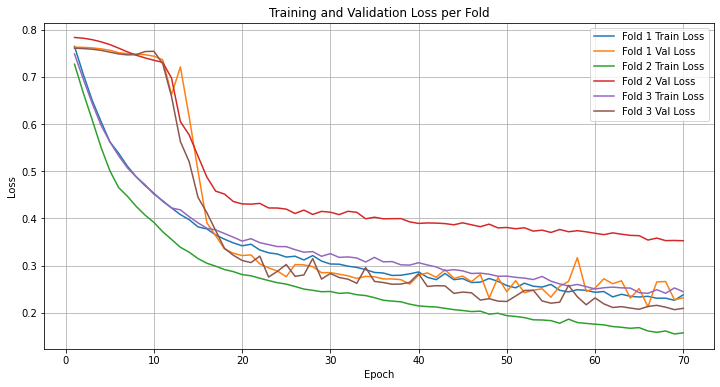

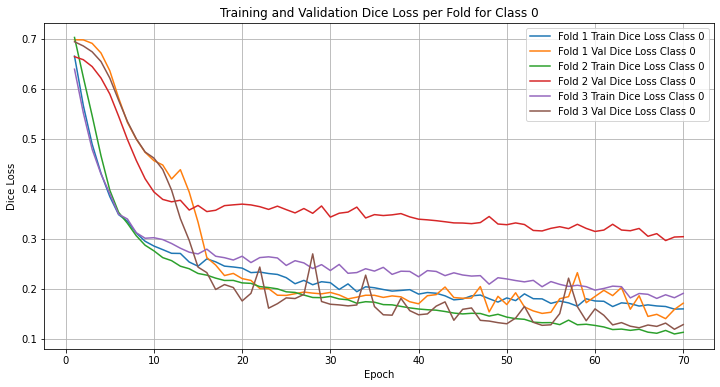

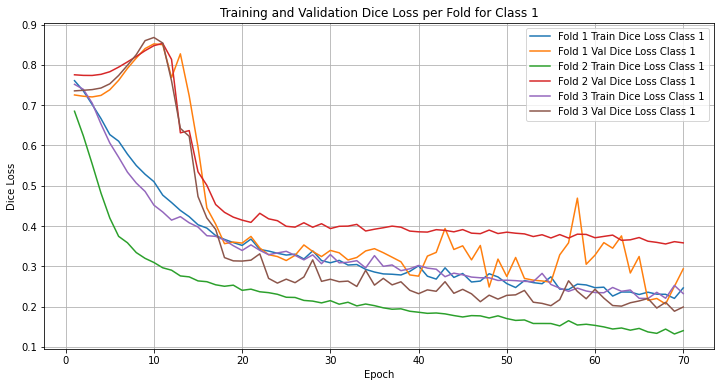

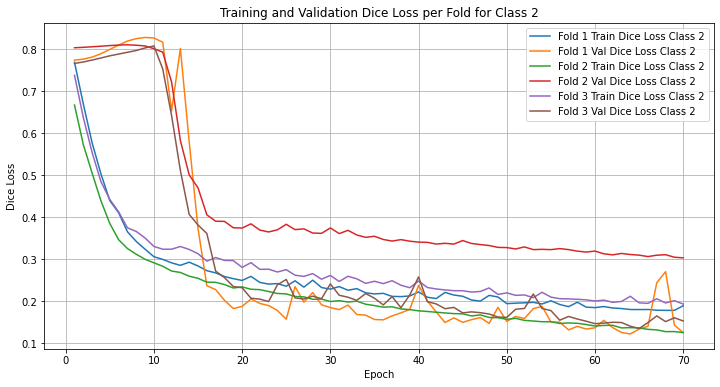

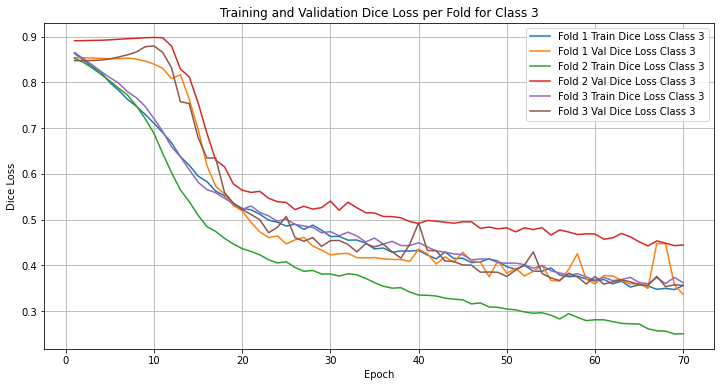

In [25]:
import pandas as pd
def plot_metrics(history, num_classes):
    # Convert history to a pandas DataFrame for easier plotting
    history_df = pd.DataFrame(history)

    num_folds = history_df['fold'].nunique()
    epochs = history_df['epoch'].max()

    # Plot Losses
    plt.figure(figsize=(12, 6))
    for fold in range(1, num_folds + 1):
        fold_history = history_df[history_df['fold'] == fold]
        plt.plot(fold_history['epoch'], fold_history['train_loss'], label=f'Fold {fold} Train Loss')
        plt.plot(fold_history['epoch'], fold_history['val_loss'], label=f'Fold {fold} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Fold')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Per-Class Dice Losses
    for c in range(num_classes):
        plt.figure(figsize=(12, 6))
        for fold in range(1, num_folds + 1):
            fold_history = history_df[history_df['fold'] == fold]
            train_dice_loss = [scores[c] for scores in fold_history['train_dice_loss']]
            val_dice_loss = [scores[c] for scores in fold_history['val_dice_loss']]
            plt.plot(fold_history['epoch'], train_dice_loss, label=f'Fold {fold} Train Dice Loss Class {c}')
            plt.plot(fold_history['epoch'], val_dice_loss, label=f'Fold {fold} Val Dice Loss Class {c}')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Loss')
        plt.title(f'Training and Validation Dice Loss per Fold for Class {c}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
# Plot the losses and Dice coefficients
plot_metrics(history, 4)


In [26]:
# Assuming you have 'history' from your training
# Convert history to DataFrame
history_df = pd.DataFrame(history)

# Convert Dice Loss to Dice Coefficient
history_df['train_dice_coef'] = history_df['train_dice_loss'].apply(lambda x: 1 - x)
history_df['val_dice_coef'] = history_df['val_dice_loss'].apply(lambda x: 1 - x)

num_classes = 4  # Adjust based on your dataset

# Initialize a dictionary to store per-fold metrics
fold_metrics = {}

# Compute per-class metrics for each fold
for fold in history_df['fold'].unique():
    fold_data = history_df[history_df['fold'] == fold]
    
    # Stack per-epoch per-class Dice coefficients
    train_dice = np.stack(fold_data['train_dice_coef'].values)
    val_dice = np.stack(fold_data['val_dice_coef'].values)
    
    # Compute mean and std per class
    train_mean = np.mean(train_dice, axis=0)
    train_std = np.std(train_dice, axis=0)
    val_mean = np.mean(val_dice, axis=0)
    val_std = np.std(val_dice, axis=0)
    
    # Store the results
    fold_metrics[fold] = {
        'train_mean': train_mean,
        'train_std': train_std,
        'val_mean': val_mean,
        'val_std': val_std,
    }

# Compute overall metrics across all folds
all_train_dice = []
all_val_dice = []

for fold in history_df['fold'].unique():
    fold_data = history_df[history_df['fold'] == fold]
    train_dice = np.stack(fold_data['train_dice_coef'].values)
    val_dice = np.stack(fold_data['val_dice_coef'].values)
    all_train_dice.append(train_dice)
    all_val_dice.append(val_dice)

# Concatenate along the epoch axis
all_train_dice = np.concatenate(all_train_dice, axis=0)
all_val_dice = np.concatenate(all_val_dice, axis=0)

# Compute overall mean and std per class
overall_train_mean = np.mean(all_train_dice, axis=0)
overall_train_std = np.std(all_train_dice, axis=0)
overall_val_mean = np.mean(all_val_dice, axis=0)
overall_val_std = np.std(all_val_dice, axis=0)

# Display per-fold metrics
for fold in sorted(fold_metrics.keys()):
    print(f"\nFold {fold} Metrics:")
    print("Class\tTrain Mean\tTrain Std\tVal Mean\tVal Std")
    for c in range(num_classes):
        print(f"{c}\t{fold_metrics[fold]['train_mean'][c]:.4f}\t\t"
              f"{fold_metrics[fold]['train_std'][c]:.4f}\t\t"
              f"{fold_metrics[fold]['val_mean'][c]:.4f}\t\t"
              f"{fold_metrics[fold]['val_std'][c]:.4f}")

# Display overall metrics
print("\nOverall Metrics Across All Folds:")
print("Class\tTrain Mean\tTrain Std\tVal Mean\tVal Std")
for c in range(num_classes):
    print(f"{c}\t{overall_train_mean[c]:.4f}\t\t"
          f"{overall_train_std[c]:.4f}\t\t"
          f"{overall_val_mean[c]:.4f}\t\t"
          f"{overall_val_std[c]:.4f}")



Fold 1 Metrics:
Class	Train Mean	Train Std	Val Mean	Val Std
0	0.7694		0.0914		0.7395		0.1533
1	0.6546		0.1314		0.5826		0.1886
2	0.7442		0.1086		0.7031		0.2454
3	0.5041		0.1439		0.4908		0.1750

Fold 2 Metrics:
Class	Train Mean	Train Std	Val Mean	Val Std
0	0.7962		0.1128		0.6297		0.0839
1	0.7696		0.1078		0.5289		0.1597
2	0.7826		0.1004		0.5717		0.1745
3	0.5800		0.1717		0.4163		0.1587

Fold 3 Metrics:
Class	Train Mean	Train Std	Val Mean	Val Std
0	0.7431		0.0793		0.7641		0.1582
1	0.6590		0.1233		0.6427		0.2119
2	0.7249		0.0995		0.6973		0.2228
3	0.4978		0.1428		0.4856		0.1773

Overall Metrics Across All Folds:
Class	Train Mean	Train Std	Val Mean	Val Std
0	0.7696		0.0979		0.7111		0.1481
1	0.6944		0.1324		0.5847		0.1936
2	0.7506		0.1057		0.6574		0.2246
3	0.5273		0.1579		0.4643		0.1739
